In [1]:
from pytorch_transformers import GPT2Tokenizer
from experiment import Intervention, Model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [3]:
def perform_intervention(intervention, effect, log_scale=False):
	
	candidate1_base_prob, candidate2_base_prob, candidate1_alt_prob, candidate2_alt_prob, candidate1_probs, candidate2_probs = model.attention_intervention_experiment(intervention, effect)
	
	candidate1 = intervention.candidates[0][1:]
	candidate2 = intervention.candidates[1][1:]
	
	odds_base = candidate2_base_prob / candidate1_base_prob
	odds_intervention = candidate2_probs / candidate1_probs
	odds_ratio_intervention = odds_intervention / odds_base
	odds_alt = candidate2_alt_prob / candidate1_alt_prob
	odds_ratio_alt = odds_alt / odds_base
	
	if log_scale:
		odds_base = torch.log(odds_base)
		odds_intervention = torch.log(odds_intervention)
		odds_ratio_intervention = torch.log(odds_ratio_intervention)
		odds_alt = torch.log(odds_alt)
		odds_ratio_alt = torch.log(odds_ratio_alt)
	
	print('Effect:', effect.upper())
	if effect=='indirect':
		print("Intervention: replace Attn(x) with Attn(x') in a specific layer/head")
	elif effect == 'direct':
		print("Intervention: replace x with x' while preserving Attn(x) in a specific layer/head")
	else:
		raise ValueError(f"Invalid effect: {effect}")
	print(f"x : {intervention.base_strings[0]}")
	print(f"x': {intervention.base_strings[1]}")
	print("Input value: x")
	print(f"Continuations compared: {candidate1} / {candidate2}")
	if log_scale:
		print("*** All values are on LOG scale ***")
	print(f"p({candidate2}|x) / p({candidate1}|x) = {odds_base:.5f}")
	print(f"p({candidate2}|x') / p({candidate1}|x') = {odds_alt:.5f}")
	print(f"Total Effect: p({candidate2}|x') / p({candidate1}|x') / p({candidate2}|x) / p({candidate1}|x) = {odds_ratio_alt:.3f}")
	if effect == 'indirect':
		print(f'Indirect Effect (p("{candidate2}"|x, Attn(x\')) / p("{candidate1}"|x, Attn(x\')) / (p("{candidate2}"|x) / p("{candidate1}"|x)):')
	elif effect == 'direct':
		print(f'Direct Effect: (p("{candidate2}"|x\', Attn(x)) / p("{candidate1}"|x\', Attn(x) / (p("{candidate2}"|x) / p("{candidate1}"|x)) =')
		
	plt.figure(figsize=(9,7)) 
	ax = sns.heatmap(odds_ratio_intervention, annot=True, annot_kws={"size": 12}, fmt=".2f")
	ax.set(xlabel='Head', ylabel='Layer')

In [4]:
# Test experiment
intervention1 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"])

intervention2 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"])

intervention3 = Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"])

intervention4 = Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])

100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: asked / answered
p(answered|x) / p(asked|x) = 0.06125
p(answered|x') / p(asked|x') = 0.37261
Total Effect: p(answered|x') / p(asked|x') / p(answered|x) / p(asked|x) = 6.084
Indirect Effect (p("answered"|x, Attn(x')) / p("asked"|x, Attn(x')) / (p("answered"|x) / p("asked"|x)):


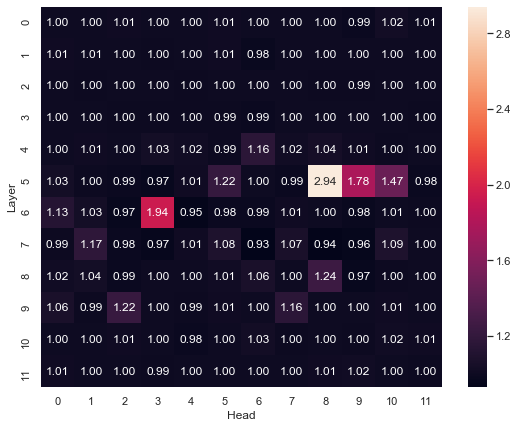

In [5]:
perform_intervention(intervention1, 'indirect')

100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: asked / answered
p(answered|x) / p(asked|x) = 0.06125
p(answered|x') / p(asked|x') = 0.37261
Total Effect: p(answered|x') / p(asked|x') / p(answered|x) / p(asked|x) = 6.084
Direct Effect: (p("answered"|x', Attn(x)) / p("asked"|x', Attn(x) / (p("answered"|x) / p("asked"|x)) =


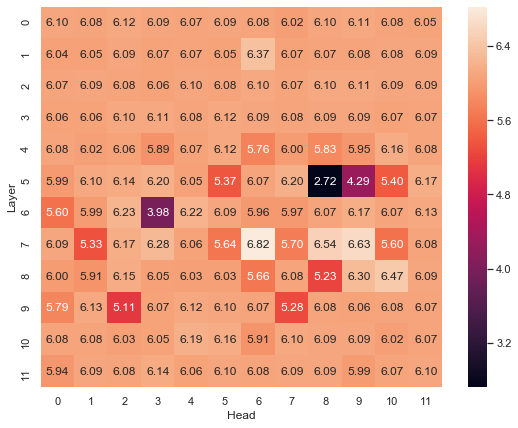

In [6]:
perform_intervention(intervention1, 'direct')

100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: requested / responded
p(responded|x) / p(requested|x) = 5.60562
p(responded|x') / p(requested|x') = 48.40155
Total Effect: p(responded|x') / p(requested|x') / p(responded|x) / p(requested|x) = 8.634
Indirect Effect (p("responded"|x, Attn(x')) / p("requested"|x, Attn(x')) / (p("responded"|x) / p("requested"|x)):


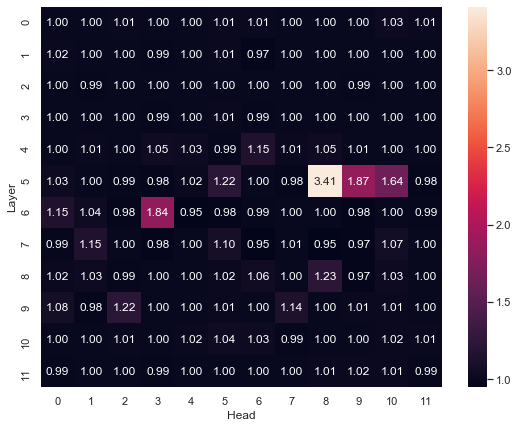

In [7]:
perform_intervention(intervention2, 'indirect')

100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: requested / responded
p(responded|x) / p(requested|x) = 5.60562
p(responded|x') / p(requested|x') = 48.40155
Total Effect: p(responded|x') / p(requested|x') / p(responded|x) / p(requested|x) = 8.634
Direct Effect: (p("responded"|x', Attn(x)) / p("requested"|x', Attn(x) / (p("responded"|x) / p("requested"|x)) =


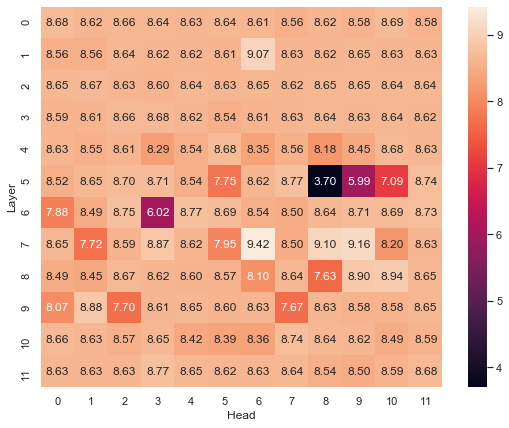

In [8]:
perform_intervention(intervention2, 'direct')

100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
Input value: x
Continuations compared: apologized / forgave
p(forgave|x) / p(apologized|x) = 0.00004
p(forgave|x') / p(apologized|x') = 0.00014
Total Effect: p(forgave|x') / p(apologized|x') / p(forgave|x) / p(apologized|x) = 3.444
Indirect Effect (p("forgave"|x, Attn(x')) / p("apologized"|x, Attn(x')) / (p("forgave"|x) / p("apologized"|x)):


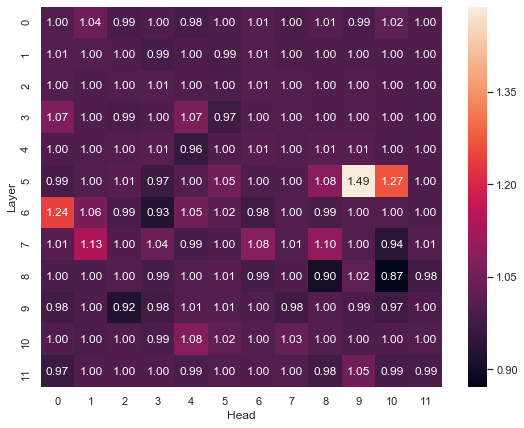

In [9]:
perform_intervention(intervention3, 'indirect')

100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
Input value: x
Continuations compared: apologized / forgave
p(forgave|x) / p(apologized|x) = 0.00004
p(forgave|x') / p(apologized|x') = 0.00014
Total Effect: p(forgave|x') / p(apologized|x') / p(forgave|x) / p(apologized|x) = 3.444
Direct Effect: (p("forgave"|x', Attn(x)) / p("apologized"|x', Attn(x) / (p("forgave"|x) / p("apologized"|x)) =


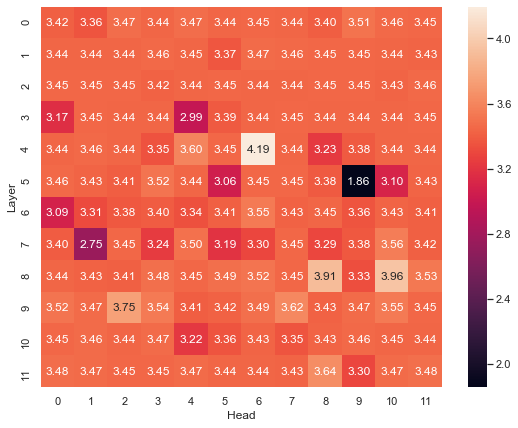

In [10]:
perform_intervention(intervention3, 'direct')

100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The nurse notified the patient that her
x': The nurse notified the patient that his
Input value: x
Continuations compared: shift / blood
p(blood|x) / p(shift|x) = 41.54527
p(blood|x') / p(shift|x') = 102.70793
Total Effect: p(blood|x') / p(shift|x') / p(blood|x) / p(shift|x) = 2.472
Indirect Effect (p("blood"|x, Attn(x')) / p("shift"|x, Attn(x')) / (p("blood"|x) / p("shift"|x)):


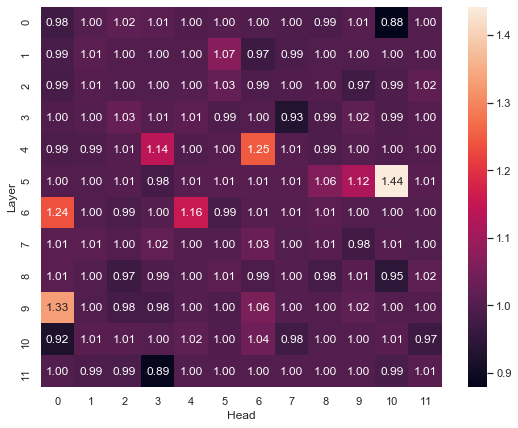

In [11]:
perform_intervention(intervention4, 'indirect')

100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
x : The nurse notified the patient that her
x': The nurse notified the patient that his
Input value: x
Continuations compared: shift / blood
p(blood|x) / p(shift|x) = 41.54527
p(blood|x') / p(shift|x') = 102.70793
Total Effect: p(blood|x') / p(shift|x') / p(blood|x) / p(shift|x) = 2.472
Direct Effect: (p("blood"|x', Attn(x)) / p("shift"|x', Attn(x) / (p("blood"|x) / p("shift"|x)) =


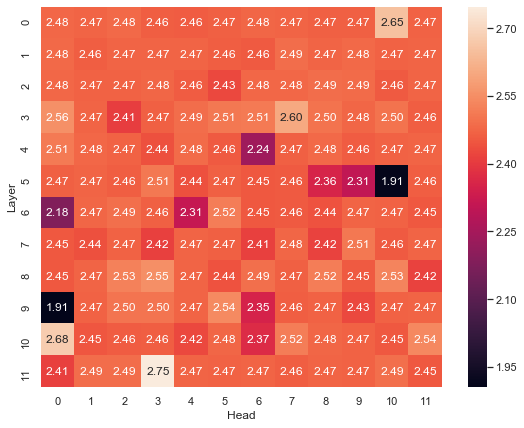

In [12]:
perform_intervention(intervention4, 'direct')

In [13]:
def perform_interventions(interventions, effect, log_scale=False):	
	odds_ratio_intervention_sum = torch.zeros((model.num_layers, model.num_heads))
	odds_ratio_alt_sum = 0

	for intervention in interventions:
		candidate1_base_prob, candidate2_base_prob, candidate1_alt_prob, candidate2_alt_prob, candidate1_probs, candidate2_probs = model.attention_intervention_experiment(intervention, effect)		
		odds_base = candidate2_base_prob / candidate1_base_prob
		odds_intervention = candidate2_probs / candidate1_probs
		odds_ratio_intervention = odds_intervention / odds_base
		if log_scale:
			odds_ratio_intervention = torch.log(odds_ratio_intervention)
		odds_ratio_intervention_sum += odds_ratio_intervention

		odds_alt = candidate2_alt_prob / candidate1_alt_prob
		odds_ratio_alt = odds_alt / odds_base
		if log_scale:
			odds_ratio_alt = torch.log(odds_ratio_alt)
		odds_ratio_alt_sum += odds_ratio_alt
		 
	mean_odds_ratio_intervention = odds_ratio_intervention_sum / len(interventions)
	mean_odds_ratio_alt = odds_ratio_alt_sum / len(interventions)

	print('*** SUMMARY ***')
	print('Effect:', effect.upper())
	if effect=='indirect':
		print("Intervention: replace Attn(x) with Attn(x') in a specific layer/head")
	elif effect == 'direct':
		print("Intervention: replace x with x' while preserving Attn(x) in a specific layer/head")
	else:
		raise ValueError(f"Invalid effect: {effect}")
	if log_scale:
		print("*** All values are LOG values ***")
	print(f"Num interventions: {len(interventions)}")
	print(f"Mean total effect: {mean_odds_ratio_alt:.2f}")
	print(f"Mean {effect} effect:")
	plt.figure(figsize=(9,7)) 
	ax = sns.heatmap(mean_odds_ratio_intervention, annot=True, annot_kws={"size": 12}, fmt=".2f")
	ax.set(xlabel='Head', ylabel='Layer')

100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


*** SUMMARY ***
Effect: INDIRECT
Intervention: replace Attn(x) with Attn(x') in a specific layer/head
Num interventions: 4
Mean total effect: 5.16
Mean indirect effect:


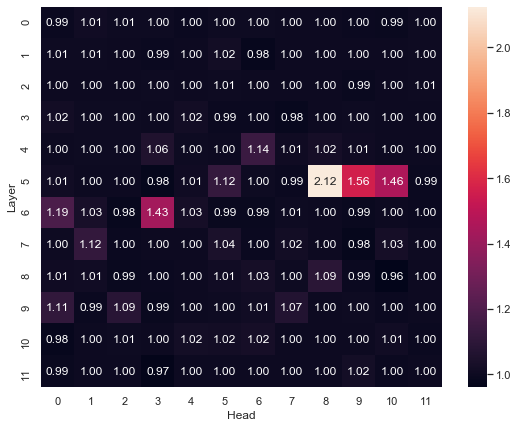

In [14]:
perform_interventions([intervention1, intervention2, intervention3, intervention4], 'indirect')

100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


*** SUMMARY ***
Effect: DIRECT
Intervention: replace x with x' while preserving Attn(x) in a specific layer/head
Num interventions: 4
Mean total effect: 5.16
Mean direct effect:


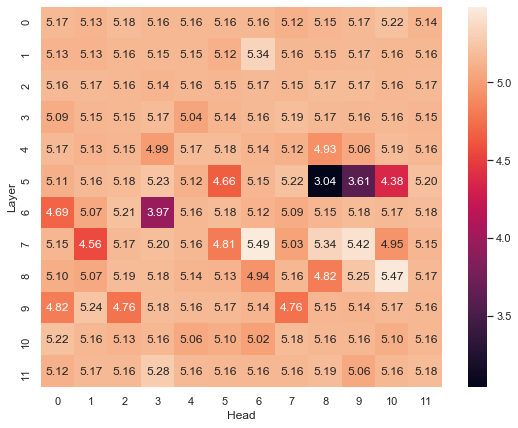

In [15]:
perform_interventions([intervention1, intervention2, intervention3, intervention4], 'direct')


